# 双塔 Youtube DNN 网络

原来的 YouTube DNN 只是单塔 DNN 结构，为了和 YoutubeSBC (Sampling-Bias-Correction) 结合在一起，将 Youtube DNN 拓展到双塔结构上。

训练的方式采用 listwise 的形式进行训练：单个正样本 + 多个负样本

模型类似于下图：

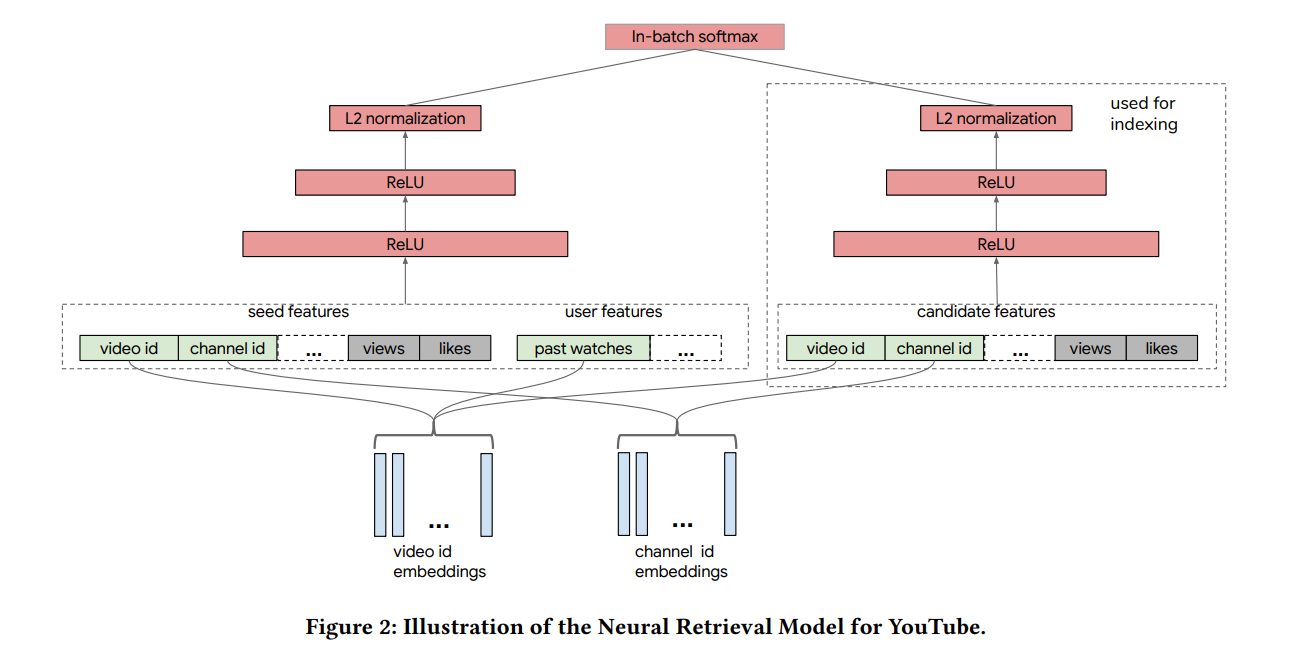

user(query) tower 输入：[user features]

item tower 输入：[video features]

## 1. data preprocess

采用的样例数据集是 movielens-100k

首先检查文件是否全部存在

In [1]:
import os
import pandas as pd
import numpy as np

data_dir = '../data/ml100k'

files = ['u.data', 'u.item', 'u.user']

for f in files:
    if not os.path.exists(os.path.join(data_dir, f)):
        raise FileNotFoundError(f'Not found file: {f} in directory {os.path.abspath(data_dir)}')

print('Check files over.')

Check files over.


In [2]:
def mapped2sequential(df:pd.DataFrame, columns: list):
    for c in columns:
        if c in df.columns:
            uniq_values = df[c].unique().tolist()
            val_encoded = {x:i for i, x in enumerate(uniq_values)}
            df[c] = df[c].map(val_encoded)
        
def min_max_normalize(df: pd.DataFrame, columns: list):
    for c in columns:
        if c in df.columns:
            df[c] = (df[c]-df[c].min()) / (df[c].max()-df[c].min())

def std_normalize(df: pd.DataFrame, columns: list):
    for c in columns:
        if c in df.columns:
            df[c] = (df[c] - df[c].mean()) / df[c].std()

In [3]:
# user --- u.user
users_col = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv(f'{data_dir}/u.user', sep='|', names=users_col)

# rating --- u.data
ratings_col = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(f'{data_dir}/u.data', sep='\t', names=ratings_col)

# movies and genres --- aggregate u.item and u.genre
movies_col = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL']
genres_col = ['genre_unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_col = movies_col + genres_col
movies = pd.read_csv(f'{data_dir}/u.item', sep='|', names=movies_col)

处理 users 数据集

In [4]:
mapped2sequential(users, ['occupation', 'zip_code'])
users['gender']=np.where(users['gender']=='M', 0, 1)

处理 movies 数据集

In [5]:
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,genre_unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


将电影稀疏的 one-hot 形式改为单字段多值形式

In [6]:
genre_encoded = {x:i for i, x in enumerate(genres_col)}
all_genre = [','.join([str(i) for i,x in enumerate(arr) if x == 1]) for arr in movies[genres_col].values]
movies['all_genres'] = all_genre

In [7]:
movies['release_date'] = movies['release_date'].fillna('01-Jan-1995')
movies['release_year'] = movies['release_date'].str[-4:]
movies['release_year']=movies['release_year'].fillna(0).astype('int64')
movies['movie_title'] = movies['movie_title'].str[:-6]
# 去除无用的列
movies = movies.drop(columns=['video_release_date', 'IMDb_URL', 'release_date']+genres_col)
mapped2sequential(movies, ['movie_title'])
std_normalize(movies, ['release_year'])

In [8]:
movies.head()

,movie_id,movie_title,all_genres,release_year
0,1,0,"3,4,5",0.393725
1,2,1,"1,2,16",0.393725
2,3,2,16,0.393725
3,4,3,"1,5,8",0.393725
4,5,4,"6,8,16",0.393725


将所有字段都合并在一起

In [9]:
ratings_all = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [10]:
ratings_all=ratings_all.sort_values(by=['user_id', 'timestamp'])
ratings_all['like_type']=np.where(ratings_all['rating']>=3, 'like', 'dislike')
mapped2sequential(ratings_all, ['user_id', 'movie_id'])
ratings_all.reset_index()
ratings_all.head()

,user_id,movie_id,rating,timestamp,movie_title,all_genres,release_year,age,gender,occupation,zip_code,like_type
1544,0,0,5,874965478,171,"1,2,8,14,15,17",-0.658907,24,0,0,0,like
1623,0,1,5,874965478,167,5,-1.079959,24,0,0,0,like
1510,0,2,5,874965518,164,8,-0.237854,24,0,0,0,like
1617,0,3,4,874965556,155,"6,16",0.183199,24,0,0,0,like
1503,0,4,5,874965677,195,8,-0.027328,24,0,0,0,like


In [11]:
std_normalize(ratings_all, ['timestamp'])

In [12]:
ratings_all.head()

,user_id,movie_id,rating,timestamp,movie_title,all_genres,release_year,age,gender,occupation,zip_code,like_type
1544,0,0,5,-1.602471,171,"1,2,8,14,15,17",-0.658907,24,0,0,0,like
1623,0,1,5,-1.602471,167,5,-1.079959,24,0,0,0,like
1510,0,2,5,-1.602463,164,8,-0.237854,24,0,0,0,like
1617,0,3,4,-1.602456,155,"6,16",0.183199,24,0,0,0,like
1503,0,4,5,-1.602434,195,8,-0.027328,24,0,0,0,like


In [13]:
ratings_all.dtypes

user_id           int64
movie_id          int64
rating            int64
timestamp       float64
movie_title       int64
all_genres       object
release_year    float64
age               int64
gender            int32
occupation        int64
zip_code          int64
like_type        object
dtype: object

### 基本将数据类型问题处理完毕，将数据分为用户数据和item数据

将用户看过的所有电影按照喜欢和不喜欢进行分类

In [14]:
movie_list_for_user = ratings_all.groupby(['user_id', 'like_type'])['movie_id'].apply(list).reset_index()
movie_list_for_user = movie_list_for_user.pivot(index='user_id', columns='like_type', values='movie_id').reset_index()
movie_list_for_user.fillna(ratings_all['movie_id'].max()+1, inplace=True)
movie_list_for_user['like'] = movie_list_for_user['like'].apply(lambda x: x if type(x) is list else [x])
movie_list_for_user['dislike'] = movie_list_for_user['dislike'].apply(lambda x: x if type(x) is list else [x])

In [15]:
movie_list_for_user

like_type,user_id,dislike,like
0,0,"[31, 32, 33, 35, 36, 55, 71, 81, 97, 99, 107, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,"[279, 298, 130, 313, 314]","[272, 250, 273, 274, 275, 276, 277, 278, 280, ..."
2,2,"[302, 317, 309, 318, 275, 250, 321, 253, 322, ...","[316, 125, 278, 319, 320, 324, 325, 326, 328, ..."
3,3,[361],"[250, 275, 309, 345, 254, 344, 355, 278, 350, ..."
4,4,"[365, 368, 369, 201, 370, 371, 373, 176, 156, ...","[126, 249, 362, 39, 363, 364, 15, 9, 37, 203, ..."
...,...,...,...
938,938,"[542, 251, 872, 936]","[332, 685, 250, 8, 247, 15, 285, 980, 1181, 71..."
939,939,"[321, 31, 254, 361, 326, 54, 1402, 267, 161, 2...","[272, 307, 276, 543, 346, 279, 310, 714, 302, ..."
940,940,"[361, 249]","[250, 309, 298, 11, 444, 10, 918, 290, 15, 27,..."
941,941,[171],"[712, 279, 346, 307, 305, 253, 357, 250, 308, ..."


In [16]:
ratings_all

,user_id,movie_id,rating,timestamp,movie_title,all_genres,release_year,age,gender,occupation,zip_code,like_type
1544,0,0,5,-1.602471,171,"1,2,8,14,15,17",-0.658907,24,0,0,0,like
1623,0,1,5,-1.602471,167,5,-1.079959,24,0,0,0,like
1510,0,2,5,-1.602463,164,8,-0.237854,24,0,0,0,like
1617,0,3,4,-1.602456,155,"6,16",0.183199,24,0,0,0,like
1503,0,4,5,-1.602434,195,8,-0.027328,24,0,0,0,like
...,...,...,...,...,...,...,...,...,...,...,...,...
51792,942,153,1,0.966401,226,"1,2,15",0.113023,22,0,5,794,dislike
51833,942,379,1,0.966401,445,"1,2,15",-0.729082,22,0,5,794,dislike
51835,942,184,1,0.966401,229,"1,2,15",-0.237854,22,0,5,794,dislike
51856,942,376,1,0.966401,446,"1,2,15",-0.027328,22,0,5,794,dislike


构造 query 数据

In [17]:
user_data = ratings_all[['user_id', 'age', 'gender', 'occupation', 'zip_code']]
user_data = user_data.drop_duplicates().reset_index().drop(columns=['index'])
user_data = user_data.merge(movie_list_for_user)
user_data  # user_data 可以导出

,user_id,age,gender,occupation,zip_code,dislike,like
0,0,24,0,0,0,"[31, 32, 33, 35, 36, 55, 71, 81, 97, 99, 107, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,53,1,1,1,"[279, 298, 130, 313, 314]","[272, 250, 273, 274, 275, 276, 277, 278, 280, ..."
2,2,23,0,2,2,"[302, 317, 309, 318, 275, 250, 321, 253, 322, ...","[316, 125, 278, 319, 320, 324, 325, 326, 328, ..."
3,3,24,0,0,3,[361],"[250, 275, 309, 345, 254, 344, 355, 278, 350, ..."
4,4,33,1,1,4,"[365, 368, 369, 201, 370, 371, 373, 176, 156, ...","[126, 249, 362, 39, 363, 364, 15, 9, 37, 203, ..."
...,...,...,...,...,...,...,...
938,938,26,1,5,791,"[542, 251, 872, 936]","[332, 685, 250, 8, 247, 15, 285, 980, 1181, 71..."
939,939,32,0,4,72,"[321, 31, 254, 361, 326, 54, 1402, 267, 161, 2...","[272, 307, 276, 543, 346, 279, 310, 714, 302, ..."
940,940,20,0,5,792,"[361, 249]","[250, 309, 298, 11, 444, 10, 918, 290, 15, 27,..."
941,941,48,1,11,793,[171],"[712, 279, 346, 307, 305, 253, 357, 250, 308, ..."


构造 item 数据

In [18]:
movie_data = ratings_all[['movie_id', 'movie_title', 'all_genres', 'release_year']].drop_duplicates().reset_index().drop(columns=['index'])
movie_data # movie_data 可以导出

,movie_id,movie_title,all_genres,release_year
0,0,171,"1,2,8,14,15,17",-0.658907
1,1,167,5,-1.079959
2,2,164,8,-0.237854
3,3,155,"6,16",0.183199
4,4,195,8,-0.027328
...,...,...,...,...
1677,1677,1656,"14,16",0.604252
1678,1678,1655,8,0.604252
1679,1679,1415,"8,14",0.604252
1680,1680,1657,5,0.323550


## 2. 构造数据集以及负采样处理

80%的用户数据作为训练数据集，10%作为验证集，10%作为评估集。

每条数据的样子 [user_feature, positive_video_feature]

在训练的时候将其他用户的视频作为负样本

In [28]:
lens = user_data.shape[0]
train_user_data = user_data[:int(lens*0.8)].reset_index()
val_user_data = user_data[int(lens*0.8):int(lens*0.9)].reset_index()
eval_user_data = user_data[int(lens*0.9):].reset_index()

In [35]:
train_user_data[['user_id', 'like']]

,user_id,like
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,"[272, 250, 273, 274, 275, 276, 277, 278, 280, ..."
2,2,"[316, 125, 278, 319, 320, 324, 325, 326, 328, ..."
3,3,"[250, 275, 309, 345, 254, 344, 355, 278, 350, ..."
4,4,"[126, 249, 362, 39, 363, 364, 15, 9, 37, 203, ..."
...,...,...
749,749,"[250, 272, 171, 275, 345, 336, 273, 280, 261, ..."
750,750,"[346, 279, 253, 457, 261, 276, 307, 331, 714, ..."
751,751,"[317, 899, 305, 911, 346, 898, 903, 253, 250, ..."
752,752,"[253, 305, 171, 265, 272, 356, 308, 298, 311, ..."


In [48]:
train_data = None
for i in train_user_data[['user_id', 'like']].values:
    df = pd.DataFrame([i[0]] * len(i[1]), columns=['user_id'])
    df = df.merge(user_data, on='user_id')
    df['movie_id'] = i[1]
    df = df.merge(movie_data, on='movie_id')
    if train_data is None:
        train_data = df
    else:
        train_data = pd.concat([train_data, df])
train_data

,user_id,age,gender,occupation,zip_code,dislike,like,movie_id,movie_title,all_genres,release_year
0,0,24,0,0,0,"[31, 32, 33, 35, 36, 55, 71, 81, 97, 99, 107, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,171,"1,2,8,14,15,17",-0.658907
1,0,24,0,0,0,"[31, 32, 33, 35, 36, 55, 71, 81, 97, 99, 107, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,167,5,-1.079959
2,0,24,0,0,0,"[31, 32, 33, 35, 36, 55, 71, 81, 97, 99, 107, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",2,164,8,-0.237854
3,0,24,0,0,0,"[31, 32, 33, 35, 36, 55, 71, 81, 97, 99, 107, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3,155,"6,16",0.183199
4,0,24,0,0,0,"[31, 32, 33, 35, 36, 55, 71, 81, 97, 99, 107, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4,195,8,-0.027328
...,...,...,...,...,...,...,...,...,...,...,...
25,753,59,1,11,496,"[349, 118, 43, 621]","[272, 345, 923, 274, 356, 8, 286, 295, 593, 63...",296,289,"13,16",0.534076
26,753,59,1,11,496,"[349, 118, 43, 621]","[272, 345, 923, 274, 356, 8, 286, 295, 593, 63...",718,733,"8,16",0.463901
27,753,59,1,11,496,"[349, 118, 43, 621]","[272, 345, 923, 274, 356, 8, 286, 295, 593, 63...",919,911,18,0.463901
28,753,59,1,11,496,"[349, 118, 43, 621]","[272, 345, 923, 274, 356, 8, 286, 295, 593, 63...",720,735,"8,17",0.463901


打乱顺序，降低负采样时候采样到同一个人的概率

In [56]:
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data

,user_id,age,gender,occupation,zip_code,dislike,like,movie_id,movie_title,all_genres,release_year
0,206,39,0,15,195,"[241, 462, 272, 294, 1170, 1002, 134, 630, 56,...","[87, 142, 298, 11, 7, 39, 352, 8, 1022, 84, 93...",74,181,"6,8",0.042848
1,101,38,0,10,96,"[298, 345, 31, 35, 869, 1024, 567, 980, 534, 8...","[250, 321, 309, 290, 16, 332, 550, 761, 302, 6...",331,329,"6,8,16",0.534076
2,462,48,1,17,419,"[974, 118, 25, 256, 205, 266, 29, 804, 463, 10...","[689, 171, 302, 280, 308, 713, 125, 769, 464, ...",1162,1151,8,0.463901
3,485,39,0,7,439,"[689, 345, 317, 272, 20, 898, 280, 685, 261, 3...","[302, 912, 265, 125, 250, 344, 786, 276, 275, ...",257,220,8,0.463901
4,457,47,0,0,414,"[37, 451, 593, 39, 115, 953, 719, 203, 297, 13...","[302, 241, 688, 27, 247, 13, 303, 294, 285, 10...",81,142,12,-1.711538
...,...,...,...,...,...,...,...,...,...,...,...
66946,377,35,0,5,346,"[298, 1060, 932, 291, 221, 448, 1029, 1043, 79...","[272, 275, 308, 759, 241, 294, 295, 13, 7, 112...",190,48,"5,14",0.323550
66947,294,31,0,7,276,"[1501, 86, 56, 946, 94, 1042, 366, 166]","[508, 516, 0, 353, 557, 95, 109, 55, 47, 173, ...",13,0,"3,4,5",0.393725
66948,456,33,1,19,413,"[473, 118, 938, 298, 803, 610, 887, 391, 936, ...","[300, 249, 308, 275, 176, 250, 243, 153, 184, ...",1036,1017,5,0.393725
66949,598,22,1,5,532,"[762, 321, 35, 294, 796, 1040, 1364]","[275, 540, 298, 716, 758, 974, 880, 938, 116, ...",13,0,"3,4,5",0.393725


## 3. 构建模型